***Kaggle Building Energetic Consumption***

*Analyse des bases de données et Data Cleaning*

Dans cette première partie nous allons nous intéresser aux différents Dataset qui ont été mis à notre disposition. Nous allons les passer en revue pour mieux les comprendre puis commencer à visualiser les informations qui nous aideront pour la suite!

In [1]:
!pip install plotly
%matplotlib nbagg

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import mplcursors
from mpldatacursor import datacursor



import os,random, math, psutil, pickle, sys,time    

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir(r'C:\Users\Pikto\Documents\Dataquest\KAGGLE')
train = pd.read_csv("train.csv" , sep=',')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
train["meter_reading"].mean()

2117.1210762169394

In [5]:
building_metadata = pd.read_csv("building_metadata.csv" , sep=',')
building_metadata.head()


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
test = pd.read_csv("test.csv" , sep=',')
weather_train = pd.read_csv("weather_train.csv" , sep=',')
weather_test = pd.read_csv("weather_test.csv" , sep=',')
sample_submission = pd.read_csv("sample_submission.csv" , sep=',')

weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


Nous allons maintenant utiliser une fonction bien connu des Data Scientist, qui permet de reduire la mémoire nécessaire pour utiliser les données : 

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building_metadata = reduce_mem_usage(building_metadata)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


Let's first work on the train dataset. We need to convert the "timestamp" column to a datetime format to use it easily and let's use it as an index for our dataset.

In [9]:
train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
train.head(4400)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
4395,1342,0,2016-01-01 01:00:00,61.950001
4396,1342,1,2016-01-01 01:00:00,0.000000
4397,1342,2,2016-01-01 01:00:00,65.910698
4398,1343,0,2016-01-01 01:00:00,193.774994


Regardons maintenant de plus près notre "meter_reading" colonne, qui est l'élement le plus important de notre dataset. C'est la valeur que nous essayerons de prédire plus tard avec les données des deux années suivantes

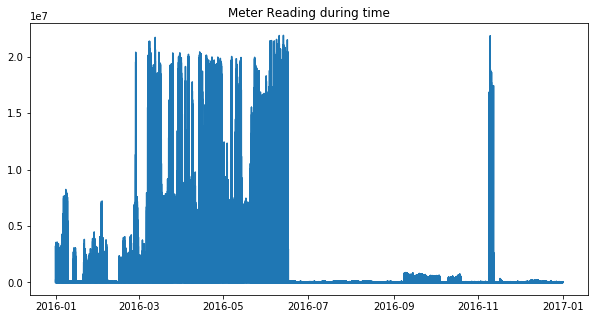

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig = plt.figure(figsize= (10,5))
plt.plot(train["timestamp"] , train["meter_reading"] )
plt.title("Meter Reading during time")
plt.show()

On s'aperçoit que la consommation relevés sur les compteurs semblent repartie sur deux périodes de l'année, une de Janvier à Juin puis un pic en Novembre. Cela ne correspond pas à la consommation que l'on pourrait imaginer dans un pays comme la France. Les batiments se trouvent donc dans un endroit au climat décalé par rapport au notre, peut être dans l'hémisphère sud ou dans plusieurs endroits à la fois.

In [11]:
train_df = train.set_index(["timestamp"])

train_df.head(200)

,building_id,meter,meter_reading
timestamp,,,
2016-01-01,0,0,0.000000
2016-01-01,1,0,0.000000
2016-01-01,2,0,0.000000
2016-01-01,3,0,0.000000
2016-01-01,4,0,0.000000
...,...,...,...
2016-01-01,171,1,0.000000
2016-01-01,171,3,5.861400
2016-01-01,172,0,111.080002


Jetons un oeil aux valeurs nulles que nous pourrions avoir dans nos dataset, prenons l'exemple du Dataset Building_Metadata.

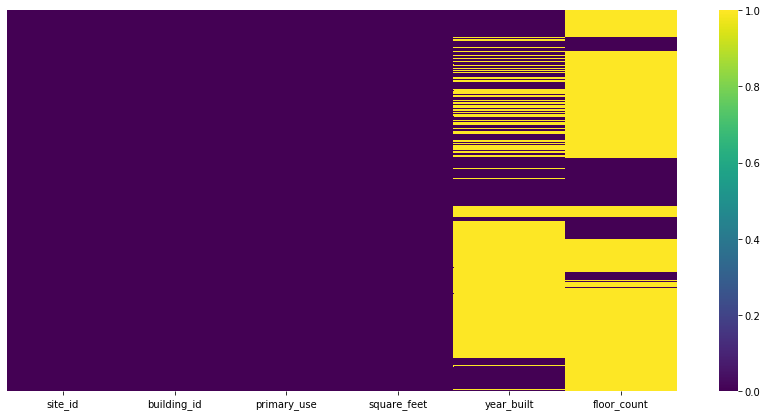

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(building_metadata.isnull(), yticklabels=False,cmap='viridis')

Nous pouvons voir qu'il manque beaucoup d'informations quand à l'année de construction et le nombre d'étages. Regardons plus précisemment pour chaque Dataset le pourcentage de valeurs manquantes

In [13]:
nul = train.isnull().sum()
percent = nul/train.count()*100
nul_train = pd.concat([nul,percent], axis = 1 , keys= ['Nul Values' , 'Percent'])
print(nul_train)

               Nul Values  Percent
building_id             0      0.0
meter                   0      0.0
timestamp               0      0.0
meter_reading           0      0.0


In [14]:
nul2 = building_metadata.isnull().sum().sort_values(ascending = False)
percent2 = (building_metadata.isnull().sum()/building_metadata.isnull().count()*100).sort_values(ascending = False)
nul_building_metadata = pd.concat([nul2,percent2], axis = 1 , keys= ['Nul Values' , 'Percent'])
print(nul_building_metadata)

             Nul Values    Percent
floor_count        1094  75.500345
year_built          774  53.416149
square_feet           0   0.000000
primary_use           0   0.000000
building_id           0   0.000000
site_id               0   0.000000


In [15]:
nul3 = weather_train.isnull().sum().sort_values(ascending = False)
percent3 = (nul3/weather_train.isnull().count()*100).sort_values(ascending = False)
nul_weather_train = pd.concat([nul3,percent3], axis = 1 , keys= ['Nul Values' , 'Percent'])
print(nul_weather_train)

                    Nul Values    Percent
cloud_coverage           69173  49.489529
precip_depth_1_hr        50289  35.979052
sea_level_pressure       10618   7.596603
wind_direction            6268   4.484414
wind_speed                 304   0.217496
dew_temperature            113   0.080845
air_temperature             55   0.039350
timestamp                    0   0.000000
site_id                      0   0.000000


In [16]:
nul4 = weather_test.isnull().sum().sort_values(ascending = False)
percent4 = (nul4/weather_test.isnull().count()*100).sort_values(ascending = False)
nul_weather_test = pd.concat([nul4,percent4], axis = 1 , keys= ['Nul Values' , 'Percent'])
print(nul_weather_test)

                    Nul Values    Percent
cloud_coverage          140448  50.658808
precip_depth_1_hr        95588  34.478057
sea_level_pressure       21265   7.670167
wind_direction           12370   4.461790
wind_speed                 460   0.165919
dew_temperature            327   0.117947
air_temperature            104   0.037512
timestamp                    0   0.000000
site_id                      0   0.000000


Nous verrons plus tard comment gérer ces valeurs nulles

Utilisons à present le coefficient de Pearson afin de voir si il y a des correlations entre deux paramètres de notre Dataset.


In [17]:
correlations = train.corr()["meter_reading"]
print(correlations)

building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64


Comme prévu, il n'existe pas de correlations entre l'identifiant d'un batiment et son relevé de compteur (!)

Pour rappel voici les valeurs du coefficient de Pearson :
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

Regardons de plus près notre "train" dataset

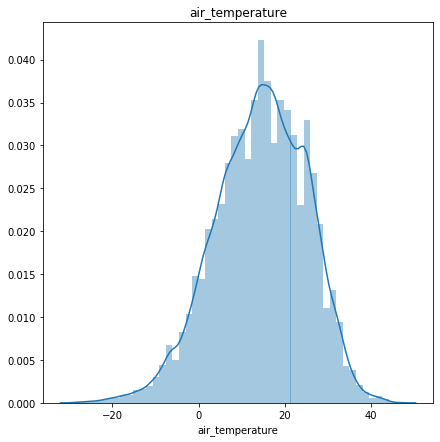

In [18]:
def distplot_weather(column):
    fig , ax = plt.subplots(figsize = (7,7))
    sns.distplot(weather_train[column].dropna()).set_title(column)
    
distplot_weather("air_temperature")

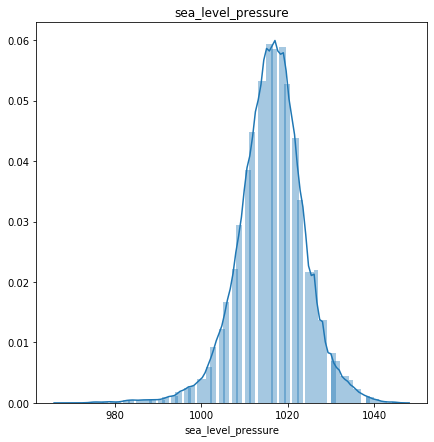

In [19]:
distplot_weather('sea_level_pressure')

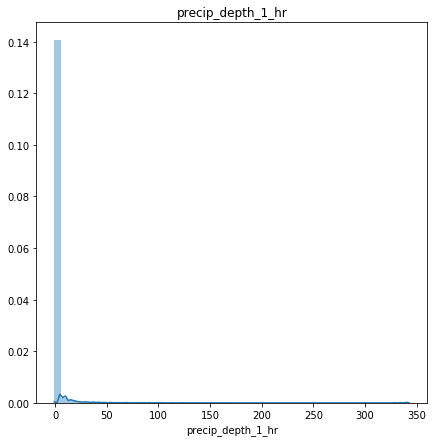

In [20]:
distplot_weather("precip_depth_1_hr")



Essayons maintenant de mettre en relation ces données météorologiques avec nos relevés de compteur grâce à l'arguement "corrwith" qui montre les corrélations entre deux Series de données

In [21]:
weather_train.corrwith(train["meter_reading"]) 

site_id              -0.004823
air_temperature       0.000196
cloud_coverage       -0.000201
dew_temperature       0.000905
precip_depth_1_hr     0.004875
sea_level_pressure   -0.002379
wind_direction       -0.002951
wind_speed            0.001463
dtype: float64

Cela aurait été trop simple, les données sont trop complexes pour qu'apparaissent des correlations aussi facilement. 

Pour plus de visibilité regroupons à présent les batiments par journée et par type de "meter" utilisé.

In [22]:
train['meter'] = pd.Categorical(train['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train = train.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train.head(1500)

meter_reading
date       building_id meter                      
2016-01-01 0           electricity        0.000000
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity        0.000000
...                                            ...
           373         hotwater                NaN
           374         electricity     6058.489746
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN

[1500 rows x 1 columns]

Créons un Dataset qui nous donne des informations de base comme la moyenne ou les valeurs max de consommation d'un type de "meter" sur chaque journée.

In [23]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05


Visualisons à présent la consommation pour chaque type de "meter" sur l'année

In [24]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum',color='meter',render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()


On peut voir que la consommation de "steam" se mesure en centaines de millions, ce qui n'est pas le cas des autres "meter" et ce qui empêche de voir clairement les évolutions des autres consommation dans le temps. 

Il peut s'agir d'un problème d'échelle, il faudrait utiliser des échelles différentes car comparer directement une consommation de "steam" et d"elctricity" ne fait pas sens.

**Outliers**

On essaye maintenant de trouver les outliers, c'est à dire les valeurs aberrantes qui pourraient s'être glissées dans le dataset.
Pour cela on créé une nouvelle colonne à notre dataset avec le building dont le "meter" est le plus élevé chaque jour.

In [25]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head(10)

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05,803
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05,1289
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07,1099
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05,1331
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05,803
5,2016-01-02,chilledwater,1.439740e+06,3157.324219,"(2016-01-02, 1289, chilledwater)",9.818726e+04,1289
6,2016-01-02,steam,3.661505e+07,116608.429688,"(2016-01-02, 1099, steam)",1.874669e+07,1099
7,2016-01-02,hotwater,2.015529e+06,13996.727539,"(2016-01-02, 1021, hotwater)",2.660082e+05,1021
8,2016-01-03,electricity,4.247301e+06,3055.612305,"(2016-01-03, 803, electricity)",1.157081e+05,803
9,2016-01-03,chilledwater,1.510352e+06,3304.927979,"(2016-01-03, 1258, chilledwater)",8.389212e+04,1258


Voyons maintenant quels sont les batiments qui reviennent le plus souvent dans le cas spécifique de l'élctricité

In [26]:
daily_train_agg[daily_train_agg["meter"] == "electricity"]["building_id_max"].value_counts()

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64

On se rend compte qu'à eux seuls, ces 6 batiments représentent l'ensemble des batiments qui consomment le plus d'éléctricité. On peut s'étonner de ce que le batiment 803 reviennent souvent, voyons de plus près de quel batiment il s'agit.

In [27]:
building_metadata.iloc[803]

site_id                7
building_id          803
primary_use    Education
square_feet       182986
year_built          1962
floor_count            3
Name: 803, dtype: object

Il parait probable que ce batiment ait des valeurs très élevées pour ses relevés de compteur si c'est une grande école.

Regardons tout de même sur un graphe si il n'y a pas de valeurs aberrantes pour les maximum d'électricité

Text(0.5, 0.98, 'Maximum consumption values for the day and energy aspect')

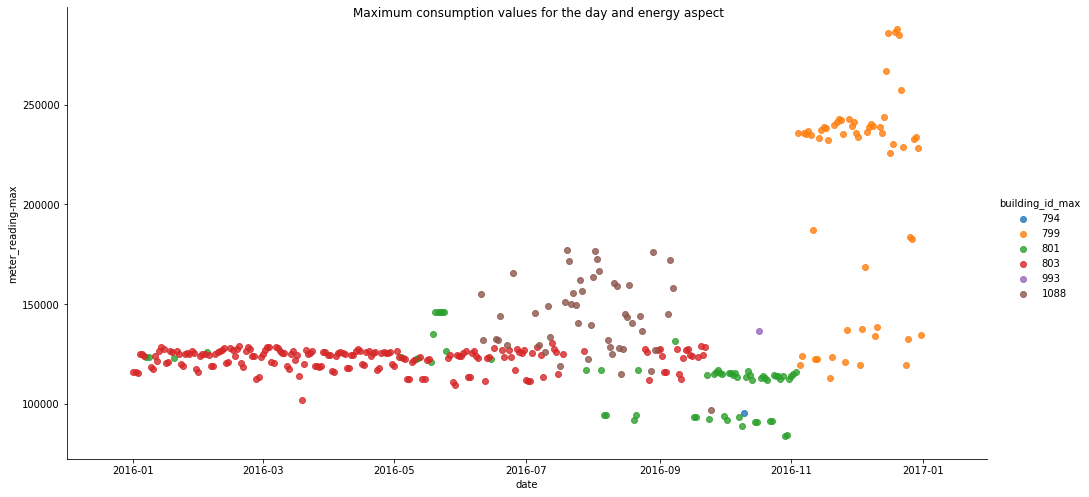

In [28]:
daily_train_agg_electricity = daily_train_agg[daily_train_agg["meter"] == "electricity"].copy()
daily_train_agg_electricity["building_id_max"] = pd.Categorical(daily_train_agg_electricity["building_id_max"])

lm = sns.lmplot(y = 'meter_reading-max' , x = "date", data =daily_train_agg_electricity, fit_reg=False , hue = "building_id_max" , height = 7 , aspect = 2)
fig = lm.fig
fig.suptitle("Maximum consumption values for the day and energy aspect" , fontsize = 12)

Aucune donnée ne semble disproportionnée, verifions de même pour les autres types de compteur ce qu'il en est.

In [29]:
daily_train_agg[daily_train_agg["meter"] == "chilledwater"]["building_id_max"].value_counts()

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64

Text(0.5, 0.98, 'Maximum consumption values for the day and energy aspect')

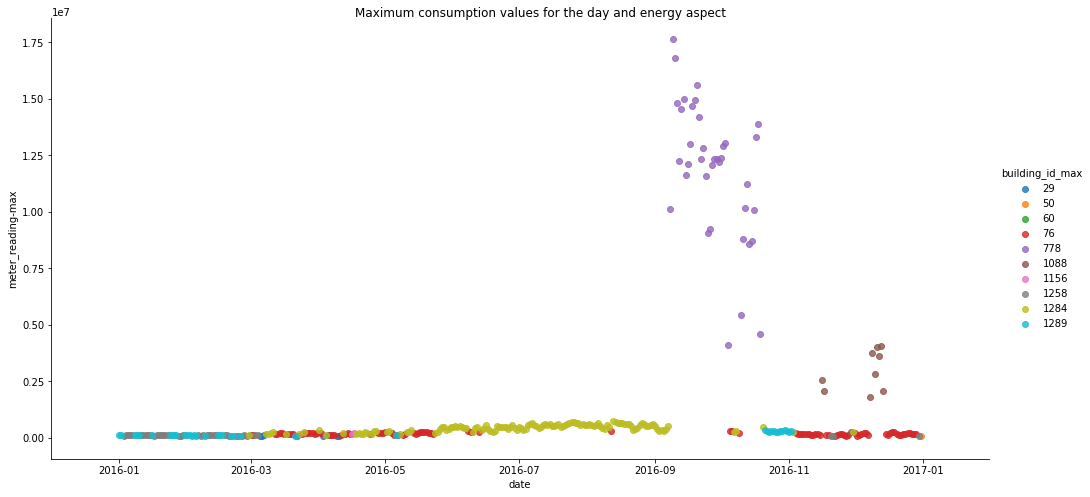

In [30]:
daily_train_agg_chilledwater = daily_train_agg[daily_train_agg["meter"] == "chilledwater"].copy()
daily_train_agg_chilledwater["building_id_max"] = pd.Categorical(daily_train_agg_chilledwater["building_id_max"])

lm = sns.lmplot(y = 'meter_reading-max' , x = "date", data =daily_train_agg_chilledwater, fit_reg=False , hue = "building_id_max" , height = 7 , aspect = 2)
fig = lm.fig
fig.suptitle("Maximum consumption values for the day and energy aspect" , fontsize = 12)

Le batiment 778 semble avoir une consommation très élevée, regardons de plus près ce à quoi sert ce batiment.

In [31]:
building_metadata.iloc[778]

site_id                                    6
building_id                              778
primary_use    Entertainment/public assembly
square_feet                           108339
year_built                               NaN
floor_count                              NaN
Name: 778, dtype: object

In [32]:
len(daily_train_agg_chilledwater)

366

Le batiment est très grand et semble être une salle de conférence. IMais les valeurs de consommation restent très élevés et sur 366 batiments il semble suspect qu'un seul ait des valeurs aussi élevé.

In [33]:
daily_train_agg[daily_train_agg["meter"] == "steam"]["building_id_max"].value_counts()

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64

Text(0.5, 0.98, 'Maximum consumption values for the day and energy aspect')

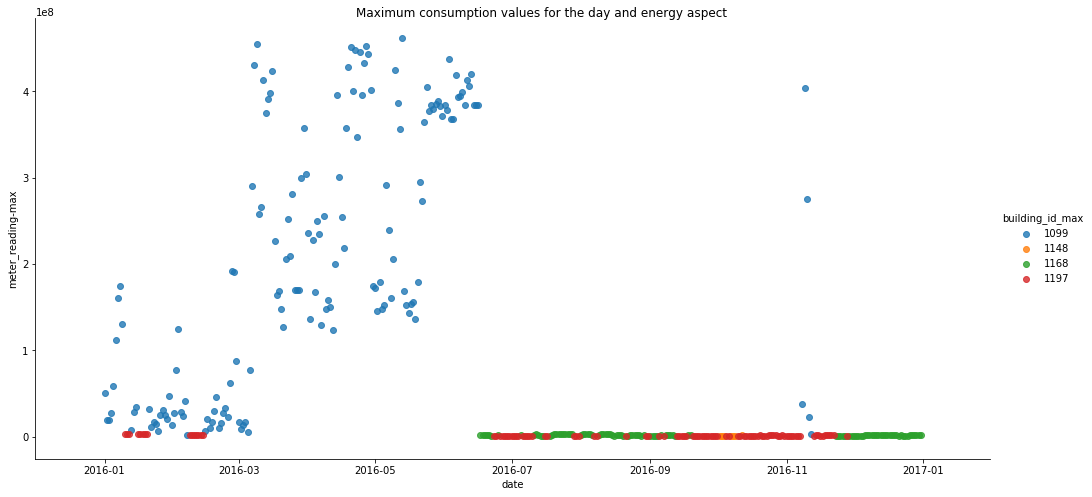

In [34]:
daily_train_agg_steam = daily_train_agg[daily_train_agg["meter"] == "steam"].copy()
daily_train_agg_steam["building_id_max"] = pd.Categorical(daily_train_agg_steam["building_id_max"])

lm = sns.lmplot(y = 'meter_reading-max' , x = "date", data =daily_train_agg_steam, fit_reg=False , hue = "building_id_max" , height = 7 , aspect = 2)
fig = lm.fig
fig.suptitle("Maximum consumption values for the day and energy aspect" , fontsize = 12)

In [35]:
building_metadata.iloc[1099]

site_id               13
building_id         1099
primary_use    Education
square_feet       332884
year_built           NaN
floor_count          NaN
Name: 1099, dtype: object

Même si le batiment est une école, le fait que uniquement ce batiment ait des valeurs si élevées interroge. Cela peut être dû à de multiples facteurs : problèmes de relevé de compteur, plusieurs compteurs fonctionnent sur une même école, mauvaise unité de mesure (KW vs W)...

In [36]:
daily_train_agg[daily_train_agg["meter"] == "hotwater"]["building_id_max"].value_counts()

1021    229
1331    120
1317      7
794       7
1323      1
1252      1
1232      1
Name: building_id_max, dtype: int64

Text(0.5, 0.98, 'Maximum consumption values for the day and energy aspect')

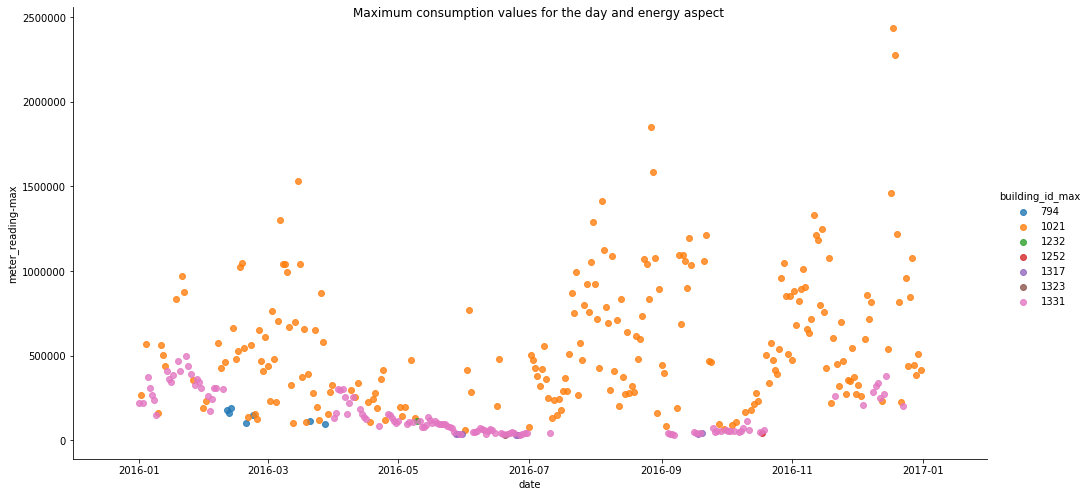

In [37]:
daily_train_agg_hotwater = daily_train_agg[daily_train_agg["meter"] == "hotwater"].copy()
daily_train_agg_hotwater["building_id_max"] = pd.Categorical(daily_train_agg_hotwater["building_id_max"])

lm = sns.lmplot(y = 'meter_reading-max' , x = "date", data =daily_train_agg_hotwater, fit_reg=False , hue = "building_id_max" , height = 7 , aspect = 2)
fig = lm.fig
fig.suptitle("Maximum consumption values for the day and energy aspect" , fontsize = 12)

In [38]:
building_metadata.iloc[1021]

site_id                                   10
building_id                             1021
primary_use    Entertainment/public assembly
square_feet                           213762
year_built                               NaN
floor_count                                2
Name: 1021, dtype: object

Là encore on peut estimer que bien qu'elles soient hautes, les valeurs ne sont pas irrationnels car ils 'agit d'un baitement public très vaste. Nous pouvons continuer.

Les écoles reviennent souvent dans les batiments qui consomme beaucoup, voyons voir si le type de batiment influe beaucoup sur la consommation énergétique.
Pour ne pas fausser les données nous allons séparer chaque type de compteur et visualiser quels sont les types de batiment qui en moyenne consomment le plus d'énergie.

In [39]:
primary_use = building_metadata[['primary_use']]
primary_use.reset_index(level = 0 , inplace = True)
primary_use = primary_use.rename(columns = {"index" : "building_id","primary_use" : "primary_use"})
primary_use = primary_use.merge(train, on=['building_id'], how='left')

electricity_primary = primary_use[(primary_use["meter"] == "electricity")]
chilledwater_primary = primary_use[(primary_use["meter"] == "chilledwater")]
steam_primary = primary_use[(primary_use["meter"] == "steam")]
hotwater_primary = primary_use[(primary_use["meter"] == "hotwater")]



In [40]:
    electricity_primary["timestamp"] = pd.to_datetime(electricity_primary["timestamp"], format='%Y-%m-%d %H:%M:%S')
    electricity_primary_mean = electricity_primary.copy()
    electricity_primary_mean["date"] = electricity_primary_mean["timestamp"].dt.date
    electricity_primary_mean = electricity_primary_mean.groupby(['date', 'primary_use' , "meter"]).mean()
    electricity_primary_mean.rename({"meter_reading" : "meter_reading_mean"} , axis =1 , inplace = True)
    electricity_primary_mean.reset_index(inplace=True)
    electricity_primary_mean.head(10)

,date,primary_use,meter,building_id,meter_reading_mean
0,2016-01-01,Education,electricity,680.279406,190.746613
1,2016-01-01,Education,chilledwater,NaN,NaN
2,2016-01-01,Education,steam,NaN,NaN
3,2016-01-01,Education,hotwater,NaN,NaN
4,2016-01-01,Entertainment/public assembly,electricity,700.974470,85.592522
5,2016-01-01,Entertainment/public assembly,chilledwater,NaN,NaN
6,2016-01-01,Entertainment/public assembly,steam,NaN,NaN
7,2016-01-01,Entertainment/public assembly,hotwater,NaN,NaN
8,2016-01-01,Food sales and service,electricity,815.400000,57.775269
9,2016-01-01,Food sales and service,chilledwater,NaN,NaN


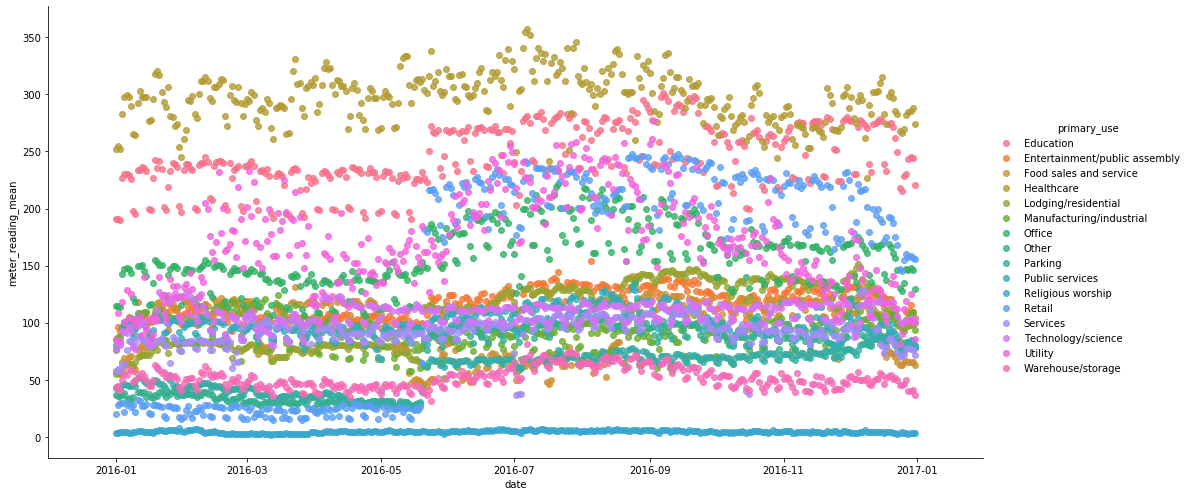

In [41]:
sns.lmplot(y = 'meter_reading_mean' , x = "date", data = electricity_primary_mean, fit_reg=False , hue = "primary_use" , height = 7 , aspect = 2)

On s'aperçoit que ce sont les batiments de "healthcare" qui consomment le plus. Ce sont certainement des hopitaux, donc des batiments très grands, sur plusieurs étages, qui ont besoin d'être à température ambiantez toute l'année. 
Viennent ensuite les écoles, ce qui semble là aussi logique.
Tout en bas se trouvent les batiments du "Retail", surement des entrepôts, qui n'ont pas besoin d'être chauffés.
Essayons de visualiser les données pour les autres compteurs différement, pour voir si cela les rend plus lisibles.

In [42]:
chilledwater_primary["timestamp"] = pd.to_datetime(chilledwater_primary["timestamp"], format='%Y-%m-%d %H:%M:%S')
chilledwater_primary_mean = chilledwater_primary.copy()
chilledwater_primary_mean["date"] = chilledwater_primary_mean["timestamp"].dt.date
chilledwater_primary_mean = chilledwater_primary_mean.groupby(['date', 'primary_use' , "meter"]).mean()
chilledwater_primary_mean.rename({"meter_reading" : "meter_reading_mean"} , axis =1 , inplace = True)
chilledwater_primary_mean.reset_index(inplace=True)
chilledwater_primary_mean.head(10)

,date,primary_use,meter,building_id,meter_reading_mean
0,2016-01-01,Education,electricity,NaN,NaN
1,2016-01-01,Education,chilledwater,844.060548,171.781570
2,2016-01-01,Education,steam,NaN,NaN
3,2016-01-01,Education,hotwater,NaN,NaN
4,2016-01-01,Entertainment/public assembly,electricity,NaN,NaN
5,2016-01-01,Entertainment/public assembly,chilledwater,949.232558,92.158836
6,2016-01-01,Entertainment/public assembly,steam,NaN,NaN
7,2016-01-01,Entertainment/public assembly,hotwater,NaN,NaN
8,2016-01-01,Food sales and service,electricity,NaN,NaN
9,2016-01-01,Food sales and service,chilledwater,743.000000,19.059450


In [43]:
import datetime
!pip install mplcursors
import mplcursors

<IPython.core.display.Javascript object>


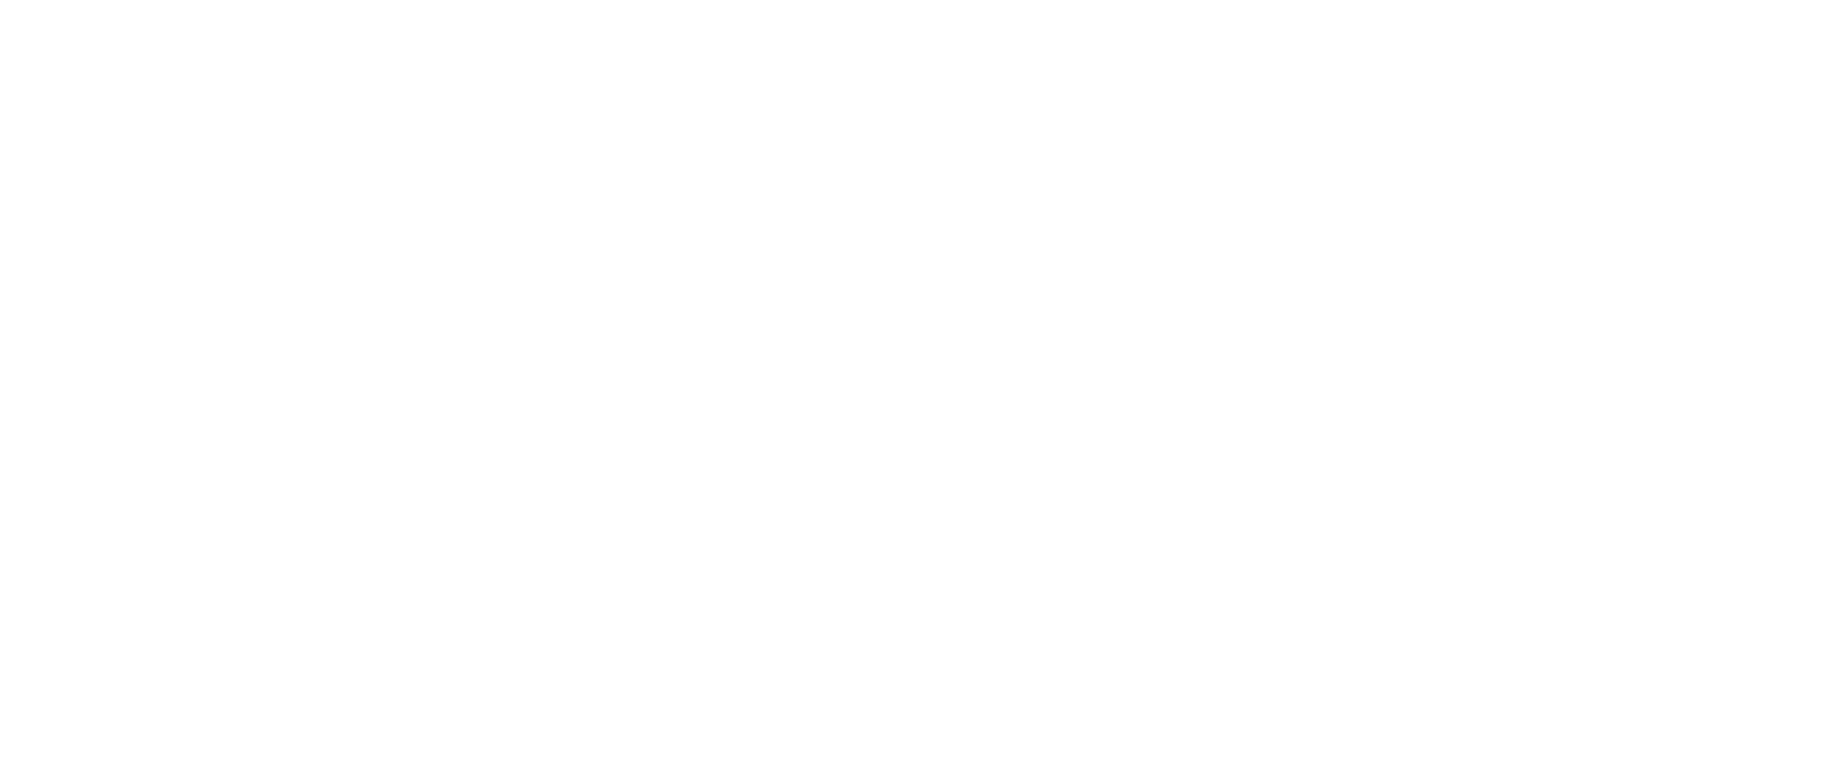

In [44]:
%matplotlib nbagg
sns.relplot(y = 'meter_reading_mean' , x = "date", data = chilledwater_primary_mean , hue = "primary_use" , height = 7, aspect = 2)
plt.xlim(datetime.date(2016, 1, 1), datetime.date(2017, 1, 1))
plt.savefig('C:/Users/Pikto/chilledwater.png', dpi=300 )
mplcursors.cursor()


Sur ce dernier graphe on peut voir que ce sont surtout les batiments publics ou les endroits de divertissement (stades, salle de conférence, mairies peut-être) qui sont bien au dessus des autres moyennes mais seulement durant une courte période de temps. Cela peut être une valeur qui augmente énormément la moyenne de ce type de batiments.  

In [45]:
steam_primary["timestamp"] = pd.to_datetime(steam_primary["timestamp"], format='%Y-%m-%d %H:%M:%S')
steam_primary_mean = steam_primary.copy()
steam_primary_mean["date"] = steam_primary_mean["timestamp"].dt.date
steam_primary_mean = steam_primary_mean.groupby(['date', 'primary_use' , "meter"]).mean()
steam_primary_mean.rename({"meter_reading" : "meter_reading_mean"} , axis =1 , inplace = True)
steam_primary_mean.reset_index(inplace=True)
steam_primary_mean.head(10)

,date,primary_use,meter,building_id,meter_reading_mean
0,2016-01-01,Education,electricity,NaN,NaN
1,2016-01-01,Education,chilledwater,NaN,NaN
2,2016-01-01,Education,steam,1058.563910,17660.683594
3,2016-01-01,Education,hotwater,NaN,NaN
4,2016-01-01,Entertainment/public assembly,electricity,NaN,NaN
5,2016-01-01,Entertainment/public assembly,chilledwater,NaN,NaN
6,2016-01-01,Entertainment/public assembly,steam,1115.259259,1314.069946
7,2016-01-01,Entertainment/public assembly,hotwater,NaN,NaN
8,2016-01-01,Food sales and service,electricity,NaN,NaN
9,2016-01-01,Food sales and service,chilledwater,NaN,NaN


<IPython.core.display.Javascript object>


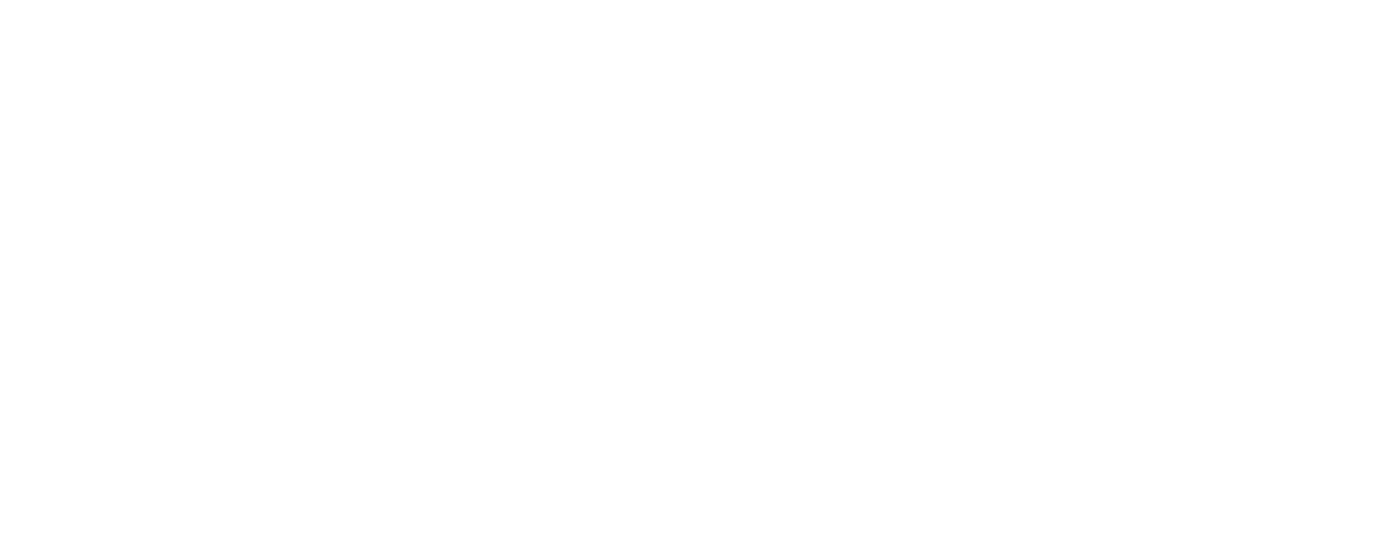

In [46]:
%matplotlib nbagg
sns.relplot(y = 'meter_reading_mean' , x = "date", data = steam_primary_mean , hue = "primary_use" , height = 5 , aspect = 2)
plt.xlim(datetime.date(2016, 1, 1), datetime.date(2017, 1, 1))
plt.savefig('C:/Users/Pikto/steam.png', dpi=300 )
mplcursors.cursor()

Ce sont les batiments scolaires qui dominent très largement sur ce type de compteur. On peut imaginer que ces batiments se trouvent dans une zone géographique où l'hiver survient de mars à juin. Enfin regardons les données pour le compteur de "hotwater"

In [47]:
hotwater_primary["timestamp"] = pd.to_datetime(hotwater_primary["timestamp"], format='%Y-%m-%d %H:%M:%S')
hotwater_primary_mean = hotwater_primary.copy()
hotwater_primary_mean["date"] = hotwater_primary_mean["timestamp"].dt.date
hotwater_primary_mean = hotwater_primary_mean.groupby(['date', 'primary_use' , "meter"]).mean()
hotwater_primary_mean.rename({"meter_reading" : "meter_reading_mean"} , axis =1 , inplace = True)
hotwater_primary_mean.reset_index(inplace=True)
hotwater_primary_mean.head(10)

,date,primary_use,meter,building_id,meter_reading_mean
0,2016-01-01,Education,electricity,NaN,NaN
1,2016-01-01,Education,chilledwater,NaN,NaN
2,2016-01-01,Education,steam,NaN,NaN
3,2016-01-01,Education,hotwater,584.93681,591.744568
4,2016-01-01,Entertainment/public assembly,electricity,NaN,NaN
5,2016-01-01,Entertainment/public assembly,chilledwater,NaN,NaN
6,2016-01-01,Entertainment/public assembly,steam,NaN,NaN
7,2016-01-01,Entertainment/public assembly,hotwater,823.06250,446.743622
8,2016-01-01,Food sales and service,electricity,NaN,NaN
9,2016-01-01,Food sales and service,chilledwater,NaN,NaN


In [48]:
%matplotlib nbagg
sns.relplot(y = 'meter_reading_mean' , x = "date", data = hotwater_primary_mean , hue = "primary_use" , height = 5 , aspect = 2)
plt.xlim(datetime.date(2016, 1, 1), datetime.date(2017, 1, 1))
plt.savefig('C:/Users/Pikto/hotwater.png', dpi=300 )
mplcursors.cursor()

<IPython.core.display.Javascript object>

Ce sont dans ce cas, comme pour le compteur "Chilledwater" les lieux publics et de divertissement qui consomment le plus. il faut imaginer que pour des raisons de sécurité il est peut être plus prudent de chauffer ces lieux à l'eau plutôt qu'au gaz. 

**Merging**

Occupons nous maintenant de fusionner toutes ces données dans un seul Dataframe afin de pouvoir utiliser ces données dans nos algorithmes.

Il nous faut tout d'abord remettre nos catégories "meter" sous forme numériques, car sinon elles ne passeront pas dans nos algorithmes.


In [49]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

building_metadata['primary_use'] = building_metadata['primary_use'].astype('category')

In [50]:
temp_df = train[['building_id']]
temp_df = temp_df.merge(building_metadata, on=['building_id'], how='left')
del temp_df['building_id']
train = pd.concat([train, temp_df], axis=1)

temp_df = test[['building_id']]
temp_df = temp_df.merge(building_metadata, on=['building_id'], how='left')

del temp_df['building_id']
test = pd.concat([test, temp_df], axis=1)
del temp_df, building_metadata

In [51]:
temp_df = train[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train = pd.concat([train, temp_df], axis=1)

temp_df = test[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test = pd.concat([test, temp_df], axis=1)

del temp_df, weather_train, weather_test

In [52]:
train.to_pickle('train_df.pkl')
test.to_pickle('test_df.pkl')
   
del train, test
gc.collect()

17006

In [53]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

In [54]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

In [55]:
train_df = train_df[(train_df["building_id"] != 778) & (train_df["building_id"] != 1099)]
test_df = test_df[(test_df["building_id"] != 778) & (test_df["building_id"] != 1099)]

In [56]:
train_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,electricity,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,53,1,0,4,1,1
1,1,electricity,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,53,1,0,4,1,1
2,2,electricity,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,53,1,0,4,1,1
3,3,electricity,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,53,1,0,4,1,1
4,4,electricity,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,53,1,0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,electricity,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875,12,52,366,23,5,31,5
20216096,1445,electricity,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875,12,52,366,23,5,31,5
20216097,1446,electricity,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875,12,52,366,23,5,31,5
20216098,1447,electricity,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875,12,52,366,23,5,31,5


In [57]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

### Données manquantes ###

Nous avons vu au début qu'il manquait de nombreuses données, nous allons les remplacer grâce à la fonction "fillna" de Pandas. Nous allons nous occuper des 4 colonnes avec le plus de valeurs manquantes.

In [58]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)



train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 



In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

**Matrice de Corrélation**

Regardons maintenant les corrélations entre les différentes données, pour éventuellement pouvoir mettre certaines colonnes de côté lors de la régression linéaire.

En effet si une colonne dépend fortement d'une autre alors autant ne garder qu'une seule des deux car cela n'ajoutera rien à nos résultats

In [60]:
BTW_train = train_df.copy()

# Matrice de corrélation
corrmat=BTW_train.corr()
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,annot=True,annot_kws={'size': 8})
plt.savefig('C:/Users/Pikto/correlation.png', dpi=300 )

<IPython.core.display.Javascript object>

Ainsi, on va supprimer les colonnes year_built, floor_count, wind_direction et dew_temperture qui ne nous apportent pas beaucoup d'informations supplémentaires que les variables auquelles elles sont corrélées pour estimer le meter (cf. la matrice de corrélation)

In [61]:
BTW_train = BTW_train.drop(columns=['site_id','year_built', 'floor_count', 'wind_direction', 'dew_temperature'])


**Données Manquantes**

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [63]:
BTW_train = BTW_train.drop(columns=['month_datetime','weekofyear_datetime', 'dayofyear_datetime', 'hour_datetime', 'day_week' , 'day_month_datetime' , 'week_month_datetime'])

In [64]:
BTW_train.isnull().sum()

building_id                 0
meter                       0
timestamp                   0
meter_reading               0
primary_use                 0
square_feet                 0
air_temperature         96631
cloud_coverage              0
precip_depth_1_hr     3748994
sea_level_pressure    1231093
wind_speed             143591
age                         0
dtype: int64

In [65]:
BTW_train['meter'] = pd.Categorical(BTW_train['meter']).rename_categories({ 'electricity' : 0, 'chilledwater' : 1, 'steam' : 2, 'hotwater' : 3})


BTW_train['timestamp'] =  pd.to_datetime(BTW_train['timestamp'])
BTW_train['Month']=pd.DatetimeIndex(BTW_train['timestamp']).month
BTW_train['Day']=pd.DatetimeIndex(BTW_train['timestamp']).day



#On transforme nos données en float32 pour alléger le fichier avant de remplir les lignes manquantes
BTW_train['wind_speed'] = BTW_train['wind_speed'].astype('float32')
BTW_train['air_temperature'] = BTW_train['air_temperature'].astype('float32')
BTW_train['precip_depth_1_hr'] = BTW_train['precip_depth_1_hr'].astype('float32')
BTW_train['cloud_coverage'] = BTW_train['cloud_coverage'].astype('float32')
BTW_train['meter_reading'] = BTW_train['meter_reading'].astype('float32')
BTW_train['square_feet'] = BTW_train['square_feet'].astype('float32')
BTW_train['sea_level_pressure'] = BTW_train['sea_level_pressure'].astype('float32')

BTW_train['sea_level_pressure'].fillna(method='ffill', inplace = True)
BTW_train['precip_depth_1_hr'].fillna(method='bfill', inplace = True)
BTW_train['cloud_coverage'].fillna(method='bfill', inplace = True)
BTW_train['wind_speed'].fillna(BTW_train['wind_speed'].mean(), inplace=True)
BTW_train['air_temperature'].fillna(BTW_train['air_temperature'].mean(), inplace=True)

In [66]:
# BTW_train= BTW_train.groupby(['meter',BTW_train['building_id'],'primary_use',BTW_train['Month'], BTW_train['Day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})
# BTW_train = BTW_train.reset_index()

In [67]:
test_df['meter'] = pd.Categorical(test_df['meter']).rename_categories({ 'electricity' : 0, 'chilledwater' : 1, 'steam' : 2, 'hotwater' : 3})


# Régression linéaire


In [68]:
BTW_linearR = pd.get_dummies(BTW_train, columns=['primary_use'])
BTW_linearR.columns

X =BTW_linearR[['building_id', 'meter', 'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet', 'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'Month', 'Day']]

A partir de cela, on lance un premier modèle de régression linéaire, basé sur toutes les variables:

In [69]:
# Create target variable
y = BTW_linearR['meter_reading']

# Train, test, split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state= 0)

# Fit
# Import model
from sklearn.linear_model import LinearRegression

# Create linear regression object
regressor = LinearRegression()

# Fit model to training data
regressor.fit(X_train,y_train)

# Predicting test set results
y_pred = regressor.predict(X_test)

In [70]:
print('Accuracy %d', regressor.score(X_test, y_test))

#Calculate R Sqaured
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

print('R^2 =', explained_variance_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred)))

Accuracy %d 0.07517611988780437
R^2 = 0.07517600594725293
Mean Absolute Error: 580.4516180068476
Mean Squared Error: 5550786.213713833
Root Mean Squared Error: 2356.01065653656


On obtient ainsi une précision de 0.075, ce qui est très mauvais.
Après cette première régression linéaire, on peut afficher les coefficients de corrélation linéaire obtenus:

In [71]:
cdf = pd.DataFrame(data = regressor.coef_, index = X.columns, columns = ['Coefficients'])
cdf
cdf.Coefficients.nlargest(10).plot(kind='barh')

On va désormais tenter d'améliorer notre modèle de régression linéaire en limitant les variables prises en compte 
(on utilisera seulement les variables aux coefficients de corrélation linéaire importants)

In [72]:
K =BTW_linearR[['meter','wind_speed', 'cloud_coverage',
                'primary_use_Education','primary_use_Entertainment/public assembly', 'primary_use_Healthcare',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking','primary_use_Religious worship',
       'primary_use_Retail','primary_use_Technology/science', 'primary_use_Utility', 'Month']]

# Create target variable
y = BTW_linearR['meter_reading']

lm = LinearRegression()

# Fit model to training data
lm.fit(K,y)

# Train, test, split
from sklearn.model_selection import train_test_split
K_train, K_test, y_train, y_test = train_test_split(K,y, test_size = .20, random_state= 0)


In [73]:
print('Accuracy %d', lm.score(K_test, y_test))

y_pred = lm.predict(K_test)

from sklearn.metrics import explained_variance_score
print('R^2 =', explained_variance_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred)))

lm.score(K,y)
regressor.score(X_train,y_train)



Accuracy %d 0.018612091253613405
R^2 = 0.018611989063532564
Mean Absolute Error: 550.1302156978521
Mean Squared Error: 5890283.102890929
Root Mean Squared Error: 2426.9905444584924


0.07494066261636079

La précision obtenue est encore plus basse, ce qui est problématique

In [74]:
cdf1 = pd.DataFrame(data = lm.coef_, index = K.columns, columns = ['Coefficients'])
cdf1 .Coefficients.nlargest(10).plot(kind='barh')

#Pas vraiment d'améliorations en tentant d'optimiser le modèle..

### Arbre de Décision ###

Passons maintenant à l'arbre de décision

In [75]:
# On passe maintenant à l'arbre de décision
XD =BTW_linearR[['building_id', 'meter', 'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet', 'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'Month', 'Day']]

# Create target variable
YD = BTW_linearR['meter_reading']

# Train, test, split
from sklearn.model_selection import train_test_split
XD_train,XD_test, YD_train, YD_test = train_test_split(XD,YD, test_size = .20, random_state= 0)

from sklearn.tree import DecisionTreeRegressor
regr_depth2 = DecisionTreeRegressor(max_depth=2)
regr_depth5 = DecisionTreeRegressor(max_depth=5)
regr_depth2.fit(XD_train, YD_train)
regr_depth5.fit(XD_train, YD_train)

y_1 = regr_depth2.predict(XD_test)
y_2 = regr_depth5.predict(XD_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_1})
df.head(20)



,Actual,Predicted
18031348,10.374900,232.471241
7467955,312.821991,232.471241
8045706,42.700001,232.471241
8681910,682.515015,232.471241
10977664,138.500000,232.471241
17372708,0.000000,232.471241
8450832,4.628900,232.471241
4449169,698.062012,232.471241
5374690,42.070000,232.471241
13463314,27.000000,232.471241


Essayons dans un premier temps avec 2 degrés de profondeur, puis avec 5.

In [76]:
#Résultats pour 2 degrés de profondeur
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
print('Mean Absolute Error:', mean_absolute_error(y_test, y_1))
print('Mean Squared Error:', mean_squared_error(y_test, y_1))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_1)))
print('R^2 =',explained_variance_score(y_test,y_1))

Mean Absolute Error: 499.5487899896177
Mean Squared Error: 5108310.085844474
Root Mean Squared Error: 2260.1570931783644
R^2 = 0.1488975814428164


In [77]:
#Résultats pour 5 degrés de profondeur
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_2})
df.head()
print('Mean Absolute Error:', mean_absolute_error(y_test, y_2))
print('Mean Squared Error:', mean_squared_error(y_test, y_2))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_2)))
print('R^2 =',explained_variance_score(y_test,y_2))

Mean Absolute Error: 386.14888833902944
Mean Squared Error: 2903878.264401757
Root Mean Squared Error: 1704.0769537793055
R^2 = 0.5161809377443669


In [78]:
import matplotlib as mpl

plt.plot(XD_test, y_1, color="blue",label="max_depth=2", linewidth=2)
plt.plot(XD_test, y_2, color="green", label="max_depth=5", linewidth=2)
mpl.rcParams['agg.path.chunksize'] = 10000
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")

plt.show()

In [79]:
yd_pred = regr_depth5.predict(XD_test)
print('XD 19',XD.columns[19], 'XD 6',XD.columns[6],'X0',XD.columns[0],'X1',XD.columns[1],'X23',XD.columns[23],'X19',XD.columns[19],'X2',XD.columns[2])

XD 19 primary_use_Services XD 6 square_feet X0 building_id X1 meter X23 Month X19 primary_use_Services X2 air_temperature


In [80]:
#Ici, on regarde de plus près quels sont les facteurs importants sous le modèle de decision tree
feat_importancesDT = pd.Series(regr_depth5.feature_importances_, index=XD.columns)
feat_importancesDT.nlargest(10).plot(kind='barh')

#On observe que désormais les paramètres de surface, temperature de l'air et mois sont les plus importantes, 
#ce qui s'avère plus cohérent

### Random Forest ###

Voyons si nous obtenons de meilleurs résultats avec un algorithme de type "Random Forest"

In [81]:
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
RFR = ske.RandomForestRegressor()
RFR.fit(XD,YD)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [82]:
RFR.score(XD,YD)
#Les random forest donnent le plus haut score d'accuracy
print('Mean Absolute Error:', mean_absolute_error(XD, YD))
print('Mean Squared Error:', mean_squared_error(XD, YD))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(XD, YD)))
print('R^2 =',explained_variance_score(XD,YD))

ValueError: y_true and y_pred have different number of output (25!=1)

In [ ]:
feat_importancesRFR = pd.Series(RFR.feature_importances_, index=XD.columns)
feat_importancesRFR.nlargest(10).plot(kind='barh')
plt.show()

**LGBM**

Après avoir étudié ces différents algorithmes, intéressons nous à un modèle plus pointu, qui a d'ailleurs connu un grand succès dans la compétition Kaggle, afin de comparer nos résultats avec ceux précédement obtenus.

In [ ]:
!pip install lightgbm
import lightgbm

**LGBM avec données par heure et MAE**


In [ ]:
train_df2 = train_df.copy()

In [ ]:

le = LabelEncoder()

train_df2['primary_use'] = le.fit_transform(train_df2['primary_use']).astype(np.int8)
train_df2['meter'] = pd.Categorical(train_df2['meter']).rename_categories({ 'electricity' : 0, 'chilledwater' : 1, 'steam' : 2, 'hotwater' : 3})

train_df2['air_temperature'] = train_df2['air_temperature'].astype('float32')
train_df2['precip_depth_1_hr'] = train_df2['precip_depth_1_hr'].astype('float32')
train_df2['cloud_coverage'] = train_df2['cloud_coverage'].astype('float32')
train_df2['meter_reading'] = train_df2['meter_reading'].astype('float32')
train_df2['square_feet'] = train_df2['square_feet'].astype('float32')
train_df2['sea_level_pressure'] = train_df2['sea_level_pressure'].astype('float32')

train_df2['sea_level_pressure'].fillna(method='ffill', inplace = True)
train_df2['precip_depth_1_hr'].fillna(method='bfill', inplace = True)
train_df2['cloud_coverage'].fillna(method='bfill', inplace = True)
train_df2['air_temperature'].fillna(train_df2['air_temperature'].mean(), inplace=True)

In [ ]:
categoricals = ["site_id", "building_id", "primary_use",  "meter"] #"hour", "weekday",

In [ ]:
drop_cols = ["sea_level_pressure", "wind_speed", "dew_temperature", "wind_direction", "timestamp"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage", 'precip_depth_1_hr', 'floor_count']

feat_cols = categoricals + numericals

In [ ]:
target = np.log1p(train_df2["meter_reading"])

del train_df2["meter_reading"] 

train_df2 = train_df2.drop(drop_cols, axis = 1)

In [ ]:
train_df2.isnull().sum()

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
from sklearn.linear_model import LinearRegression
a=0
models = []
for train_index, val_index in kf.split(train_df2[feat_cols], train_df2['building_id']):
    train_X = train_df2[feat_cols].iloc[train_index]
    val_X = train_df2[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    regressor = LinearRegression()
    regressor.fit(train_X,train_y)
    y_pred = regressor.predict(val_X)
    print(regressor.score(val_y, y_pred))
    a=a+regressor.score(val_y, y_pred)
print(a/5)

In [ ]:
train_df2 

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

from sklearn.model_selection import train_test_split

train_X,val_X,train_y,val_y = train_test_split(train_df2, target, test_size = .20, random_state= 0)
lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
gbm = lgb.train(params,lgb_train, num_boost_round=500, valid_sets=(lgb_train, lgb_eval),early_stopping_rounds=50, verbose_eval = 50)
models.append(gbm)

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []
for train_index, val_index in kf.split(train_df2[feat_cols], train_df2['building_id']):
    train_X = train_df2[feat_cols].iloc[train_index]
    val_X = train_df2[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 10
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []
for train_index, val_index in kf.split(train_df2[feat_cols], train_df2['building_id']):
    train_X = train_df2[feat_cols].iloc[train_index]
    val_X = train_df2[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)

**LGBM avec données par heure et mae avec BTW_train**

On repart de BTW_train comme DataFrame merged.

In [ ]:
>

In [ ]:
categoricals = [ "building_id", "primary_use",  "meter"]
numericals = ["square_feet", "age", "air_temperature", "cloud_coverage", 'precip_depth_1_hr']
feat_cols = categoricals + numericals

In [ ]:
target = np.log1p(trainv2["meter_reading"])

del trainv2["meter_reading"] 

# trainv2 = trainv2.drop(drop_cols, axis = 1)

In [ ]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'mae'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []
for train_index, val_index in kf.split(trainv2[feat_cols], trainv2['building_id']):
    train_X = trainv2[feat_cols].iloc[train_index]
    val_X = trainv2[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)

In [ ]:
import gc
del trainv2 #, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

In [ ]:
testv2 = test_df[feat_cols]


In [ ]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(testv2.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(testv2.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

In [ ]:
**Algo Boris**


In [ ]:
import lightgbm as lgb

# LGBM
params = {'num_leaves': 128, 'min_child_samples': 79, 'objective': 'regression', 'max_depth': 9, 'learning_rate': 0.3,
          'boosting_type': 'gbdt', 'subsample_freq': 1, 'subsample': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'colsample_bytree': 1.0}

reg = lgb.LGBMRegressor(**params, n_estimators=1000, silent=False)
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_cv = reg.predict(X_cv)